### Optimisation of a Neural Network for Image Classification

In [58]:
# Libraries will be imported as needed at that particular point
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### Data Loading

In [3]:
# loading the data, using pandas\
X_train_df = pd.read_csv("./Datasets/fashion-mnist_train.csv")
X_test_df = pd.read_csv("./Datasets/fashion-mnist_test.csv")

In [7]:
X_train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data pre-processing

In [4]:
y_train_df = X_train_df["label"]

In [9]:
y_train_df.head

<bound method NDFrame.head of 0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64>

In [5]:
# removing the labels
X_train_df = X_train_df.iloc[:, 1:]

In [6]:
X_train_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_train_df.shape

(60000, 784)

#### Ready data variables to be used in training, validation and testing

In [8]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.2,
            random_state=30,
            stratify=y_train
)
X_test = X_test_df.to_numpy()

# Data normalisation
X_train = X_train.astype('float32')/ 255.0      # in-place division, kinda fast than normal division of having to create a new array in memery
X_test = X_test.astype('float32')/ 255.0
X_val = X_val.astype('float32')/ 255.0

In [9]:
# Coverting to tensors. If getting an error, run the above box again

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
X_val = torch.from_numpy(X_val).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()

In [10]:
X_train.shape[0]

48000

### Building and training a Baseline model

In [73]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim,
                 learning_rate = 0.001, optim_method = "Adam", activation_fn = "ReLU"):
        super(MultiLayerPerceptron, self).__init__()
        # defining the layers (w*x + b)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)    # Hidden Layer 1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)  # Hidden Layer 2
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  # Output Layer

        # Activation functions
        if activation_fn == "ReLU":
            self.activation_fn = nn.ReLU()
        elif activation_fn == "Sigmoid":
            self.activation_fn = nn.Sigmoid()
        else:
            raise ValueErro(f"Not supporting activation func: {activation_fn}")

        # extras for the model optimization
        self.losses_training = []
        self.losses_validation = []
        self.loss_fn = nn.CrossEntropyLoss() # torch gives us this
        if optim_method == "Adam":
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif optim_method == "SGD":
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        elif optim_method == "RMSprop":
            self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {optim_method}")
        
    def forward(self, X):
        # defining the architcture
        X = self.flatten(X) # flattening
        layer_one = self.activation_fn(self.fc1(X))
        layer_two = self.activation_fn(self.fc2(layer_one))
        output = self.fc3(layer_two)  # just the weights
        return output  # returning the compututed 
        
    def train_model(self, X_train, y_train, X_val = None, y_val = None, num_iters = 10, batch_size = 64):  # maybe patience as stoping condition  too, will see
        # Data is already in tensors
        self.train()  # setting the model to training mode
        n_samples = X_train.shape[0]  # number of samples we have in the data
        val_accuracy = 0;
        
        # Training loop
        for epoch in range(num_iters):
            epoch_loss = 0

            for i in range(0, n_samples, batch_size): # training in batches
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # forwad pass
                outputs = self.forward(X_batch)  # outputs given by the activation fucntion
                loss = self.loss_fn(outputs, y_batch) # the loss

                # backwards propagation
                self.optimizer.zero_grad()   # clearing old gradients
                loss.backward()              # computing new gradients
                self.optimizer.step()        # updating weights

                epoch_loss += loss.item()  
            # Print the loss for each epoch
            self.losses_training.append(epoch_loss / len(X_train))
            print(f"The loss at epoch {epoch+1} is {epoch_loss/len(X_train):.5f}")
    
            # validation at each epoch
            if X_val is not None and y_val is not None:
                self.eval() # setting to evaluation mode
                with torch.no_grad():  # disabling gradient computation for validation
                    
                    val_outputs = self.forward(X_val)
                    val_loss = self.loss_fn(val_outputs, y_val)
                    self.losses_validation.append(val_loss)
                    # computing the accuracy
                    _, preds = torch.max(val_outputs, 1)
                    correct = (preds == y_val).sum().item()
                    val_acc = correct / len(y_val)
            
                print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_acc*100:.2f}%")
                val_accuracy = round(val_acc*100, 2)
                self.train()  # switching back to training mode
            
        return val_accuracy 

#### Training Base Line model

In [12]:

input_dim = X_train.shape[1]
model = MultiLayerPerceptron(input_dim, 128, 64, 10)

#Betting our data is pre-processed correctly
base_training = model.train_model(X_train, y_train, X_val, y_val)

The loss at epoch 1 is 0.00924
Validation Loss: 0.4543, Validation Accuracy: 82.98%
The loss at epoch 2 is 0.00641
Validation Loss: 0.4080, Validation Accuracy: 84.62%
The loss at epoch 3 is 0.00577
Validation Loss: 0.3838, Validation Accuracy: 85.67%
The loss at epoch 4 is 0.00535
Validation Loss: 0.3579, Validation Accuracy: 86.75%
The loss at epoch 5 is 0.00501
Validation Loss: 0.3452, Validation Accuracy: 87.24%
The loss at epoch 6 is 0.00476
Validation Loss: 0.3305, Validation Accuracy: 87.62%
The loss at epoch 7 is 0.00450
Validation Loss: 0.3306, Validation Accuracy: 87.66%
The loss at epoch 8 is 0.00430
Validation Loss: 0.3225, Validation Accuracy: 87.82%
The loss at epoch 9 is 0.00412
Validation Loss: 0.3244, Validation Accuracy: 87.97%
The loss at epoch 10 is 0.00393
Validation Loss: 0.3222, Validation Accuracy: 88.08%


In [13]:
print(base_training)

88.08


In [55]:
val_loss = model.losses_validation
train_loss = model.losses_training

####  Hyperparameter Optimisation Experiment

In [16]:
%%capture  
# remove "%%capture" to see all the logs
learning_rates = [0.1, 0.01, 0.001]
optimization_methods = ["Adam","SGD","RMSprop"]
activation_functions = ["ReLU", "Sigmoid"]

results = []
models = []

# This not good. I Dont like running 3 nested loop. (efficiency?)
# But will do it for sake of time and expirimenting.
for actv_func in range(len(activation_functions)):
    for optim_method in range(len(optimization_methods)):
        for lr in range(len(learning_rates)):
            print(f"THE ACTIVATION FUNCTION USED: {activation_functions[actv_func]}")
            print(f"THE OPTIMIZATION METHOD: {optimization_methods[optim_method]}")
            print(f"TRAINING AT LEARNING RATE OF: {learning_rates[lr]}")
            model_optim = MultiLayerPerceptron(input_dim,
                                               128, 64, 10,
                                               learning_rate = learning_rates[lr],
                                               optim_method = optimization_methods[optim_method],
                                               activation_fn = activation_functions[actv_func])
            experimenting_training = model_optim.train_model(X_train, y_train, X_val, y_val)
            print("")
            models.append({experimenting_training:model_optim})
            results.append({
                "Activation Function": activation_functions[actv_func],
                "Optimizer": optimization_methods[optim_method],
                "Learning Rate": learning_rates[lr],
                "Validation Accuracy": experimenting_training
            })
        print("")
    print("")

#### Analysis and Reporting 

In [56]:
df_results = pd.DataFrame(results)
df_results

,Activation Function,Optimizer,Learning Rate,Validation Accuracy
0,ReLU,Adam,0.100,19.90
1,ReLU,Adam,0.010,86.81
2,ReLU,Adam,0.001,88.14
3,ReLU,SGD,0.100,87.62
4,ReLU,SGD,0.010,84.38
5,ReLU,SGD,0.001,65.24
6,ReLU,RMSprop,0.100,10.98
7,ReLU,RMSprop,0.010,84.73
8,ReLU,RMSprop,0.001,88.32
9,Sigmoid,Adam,0.100,43.77


##### Heatmap for ReLU

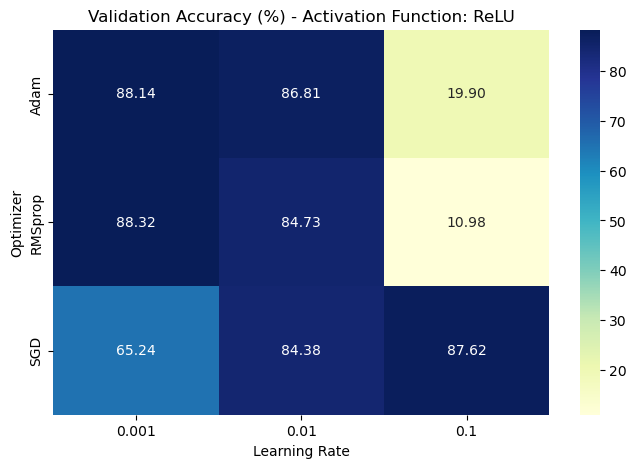

In [57]:
subset_relu = df_results[df_results["Activation Function"] == "ReLU"]
heatmap_data = subset_relu.pivot(index="Optimizer", columns="Learning Rate", values="Validation Accuracy")

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Validation Accuracy (%) - Activation Function: ReLU")
plt.show()

##### Heatmap for Sigmoid

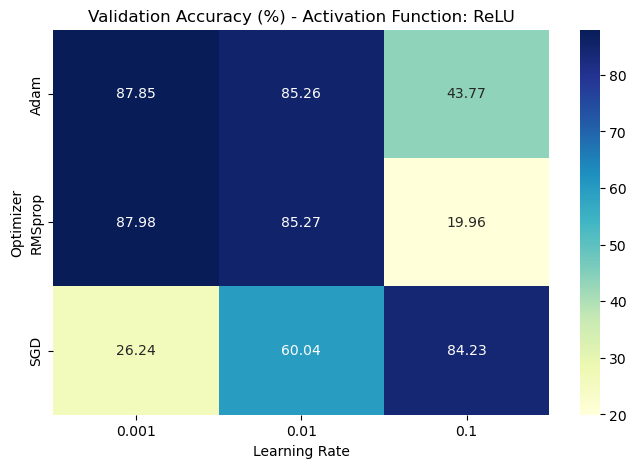

In [26]:
subset_sigmoid = df_results[df_results["Activation Function"] == "Sigmoid"]
heatmap_data = subset_sigmoid.pivot(index="Optimizer", columns="Learning Rate", values="Validation Accuracy")

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Validation Accuracy (%) - Activation Function: ReLU")
plt.show()

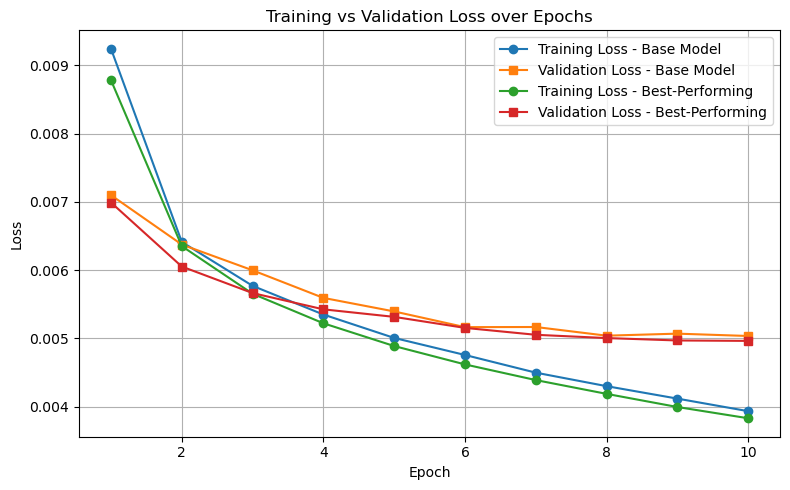

In [60]:
val_loss_nofloat = [loss.item() for loss in val_loss]
val_loss_scaled = [loss/64 for loss in val_loss_nofloat]

# Create epoch range
epochs = range(1, len(train_loss) + 1)

# Plot losses for the base model
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss - Base Model', marker='o')
plt.plot(epochs, val_loss_scaled, label='Validation Loss - Base Model', marker='s')

# Best performing model is model 8 in our models array, with key as 88.32
best_performing = models[8][88.32]
best_val_loss = best_performing.losses_validation
best_train_loss = best_performing.losses_training
best_val_loss_nofloat = [loss.item() for loss in best_val_loss]
best_val_loss_scaled = [loss/64 for loss in best_val_loss_nofloat]

plt.plot(epochs, best_train_loss, label='Training Loss - Best-Performing', marker='o')
plt.plot(epochs, best_val_loss_scaled, label='Validation Loss - Best-Performing', marker='s')


plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



##### Confusion matrix for  best model's predictions on the validation set

In [74]:
## forgot to get the predicted value in the validation set.
# The following offset that mistake
best_performing.eval()
with torch.no_grad():
    val_outputs = best_performing.forward(X_val)
    _, y_pred = torch.max(val_outputs, 1)

# Convertin to numpy for confusion matrix
y_val_np = y_val.numpy()
y_pred_np = y_pred.numpy()

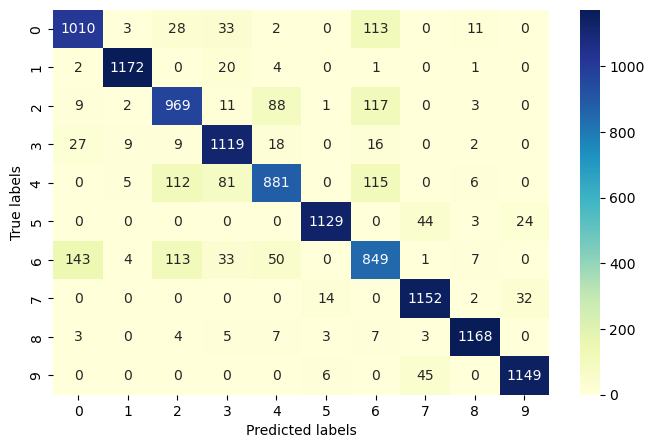

In [75]:
c_matrix = confusion_matrix(y_val_np, y_pred_np) 

plt.figure(figsize = (8,5))
sns.heatmap(c_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.show()